In [7]:
# Importing necessary libraries
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.metrics import classification_report
from time import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [8]:
# Now load the encoded dataset.
df1 = pd.read_csv('encoded_retractions35215_V10.csv')
df1.head()

,Journal,ArticleType,CitationCount,SJR Best Quartile,SJR,H index,TimeToRetraction,IsInternationalCollaboration,ArticleAge,IsPaywalled,LevelOfSeriousness,Subject,Institution,Publisher,Country,Author,Cluster
0,4884,56,5,1.0,0.900000,315.000000,280,0,304,0,3.0,0.194505,0.125899,0.028624,0.001657,0.000010,1
1,3474,56,2,3.0,0.290000,23.000000,1089,0,1115,0,3.0,0.156626,0.062955,0.099475,0.011070,0.000009,1
2,3474,56,14,3.0,0.290000,23.000000,1344,0,1367,0,3.0,0.156626,0.062955,0.099475,0.011070,0.000008,1
3,5106,10,0,5.0,1.458473,157.555562,0,0,492,0,1.0,0.232383,0.050368,0.099475,0.064331,0.000009,1
4,964,56,2,1.0,0.764000,48.000000,351,1,520,0,0.0,0.166709,0.035978,0.116854,0.024918,0.000009,4


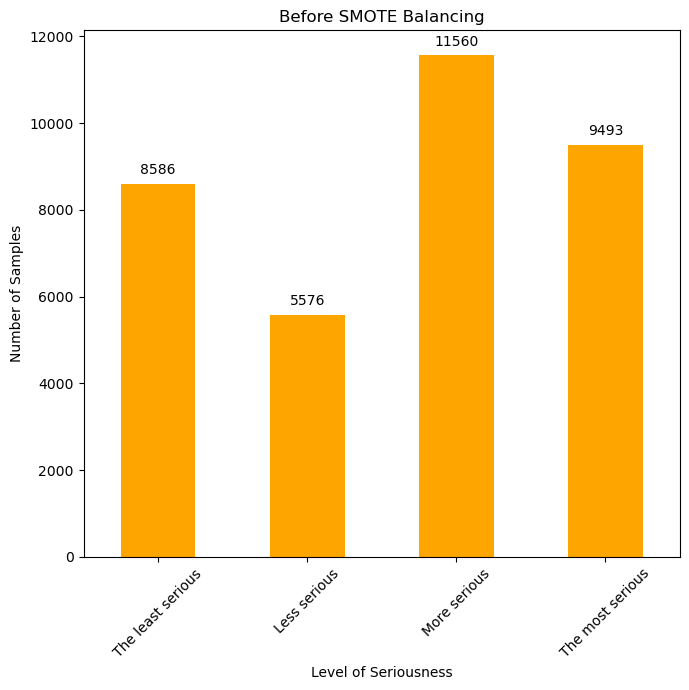

In [9]:
# Check the balance of 4 subsets in the dataset.
label_counts = df1['LevelOfSeriousness'].value_counts().sort_index()  # Ensure the labels are sorted

plt.figure(figsize=(7, 7))
ax = label_counts.plot(kind='bar', color='orange')  # 'ax' captures the plot axes
plt.title('Before SMOTE Balancing')
plt.xlabel('Level of Seriousness')
plt.ylabel('Number of Samples')

# Set custom x-tick labels
plt.xticks(ticks=range(4), labels=['The least serious', 'Less serious', 'More serious', 'The most serious'], rotation=45)

# Annotate each bar with its height value
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

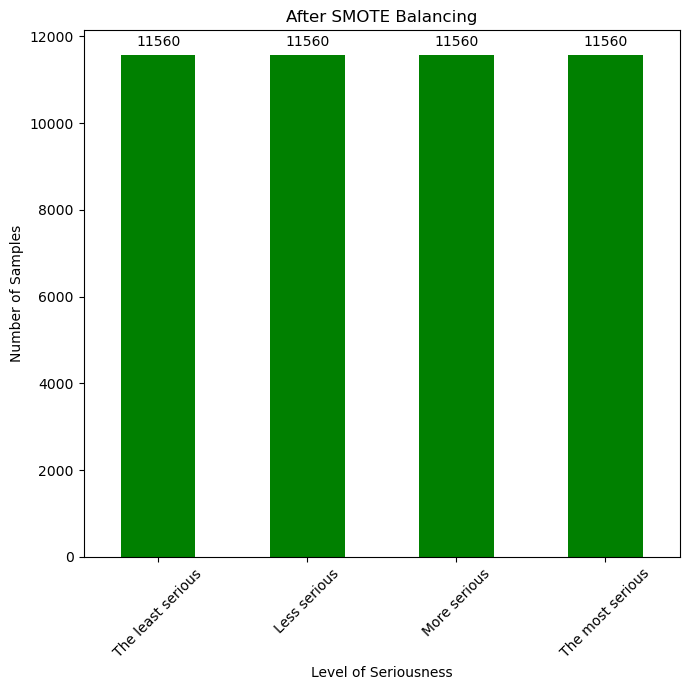

In [10]:
# Separate feataures and the target variable
X = df1.drop('LevelOfSeriousness', axis=1)
y = df1['LevelOfSeriousness']

# Apply SMOTE
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert y_resampled to a DataFrame and count the occurrences of each class
y_resampled_df = pd.DataFrame(y_resampled, columns=['LevelOfSeriousness'])
label_counts_resampled = y_resampled_df['LevelOfSeriousness'].value_counts().sort_index()

# Plot the balanced data
plt.figure(figsize=(7, 7))
ax = label_counts_resampled.plot(kind='bar', color='green')  # 'ax' captures the plot axes
plt.title('After SMOTE Balancing')
plt.xlabel('Level of Seriousness')
plt.ylabel('Number of Samples')

# Set custom x-tick labels
plt.xticks(ticks=range(4), labels=['The least serious', 'Less serious', 'More serious', 'The most serious'], rotation=45)

# Annotate each bar with its height value
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

### Build model

In [11]:
# For Random Forest, preprocessing like standardization is not necessary, but let's keep the dataset split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

# Initialize the Random Forest classifier
rfc = RandomForestClassifier(random_state=0)

# Applying 5-fold cross-validation
cv_results = cross_validate(rfc, X_train, y_train, cv=5,
                            scoring=('accuracy', 'precision_macro', 'recall_macro', 'f1_macro'))

# Training the model on the full training data
rfc.fit(X_train, y_train)

# Predicting on the test set
y_pred = rfc.predict(X_test)

# Evaluation metrics
accuracy_RF = accuracy_score(y_test, y_pred)
precision_RF = precision_score(y_test, y_pred, average='macro')
recall_RF = recall_score(y_test, y_pred, average='macro')
f1_RF = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy_RF)
print("Precision:", precision_RF)
print("Recall:", recall_RF)
print("F1-Score:", f1_RF)

Accuracy: 0.7840614186851211
Precision: 0.7955785149752016
Recall: 0.7847880179301802
F1-Score: 0.786490118392096


#### Model Optimisation: Hyper-parameters Tuning

##### Random Search

In [14]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_grid,
    n_iter=200,  # Number of parameter settings that are sampled
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    random_state=0,
    verbose=2
)

# Fit the random search model
start_time = time()
random_search.fit(X_train, y_train)
end_time = time()

# Get the best estimator
best_rfc = random_search.best_estimator_

# Predict using the best estimator
y_pred_optimized = best_rfc.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred_optimized)

# Print the classification report and best parameters
print(report)
print(f"Best parameters: {random_search.best_params_} with score: {random_search.best_score_:.4f}")
print(f"Time taken for RandomizedSearchCV: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
              precision    recall  f1-score   support

         0.0       0.80      0.72      0.76      2398
         1.0       0.69      0.85      0.76      2309
         2.0       0.94      0.79      0.86      2256
         3.0       0.78      0.81      0.79      2285

    accuracy                           0.79      9248
   macro avg       0.80      0.79      0.79      9248
weighted avg       0.80      0.79      0.79      9248

Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40} with score: 0.7861
Time taken for RandomizedSearchCV: 11190.04 seconds


RF on the whole dataset with hyperparameter tuning has no improvement compared to the default parameters (accuracy: 78.40% --> 78.61%).